In [51]:
import numpy as np

In [52]:
def rastrigin(x: np.ndarray, A = 10):
    def cos(x, A = 10):
        return x**2 + A*np.cos(2*np.pi*x)
    return len(x) + np.sum(cos(x, A))

44.0

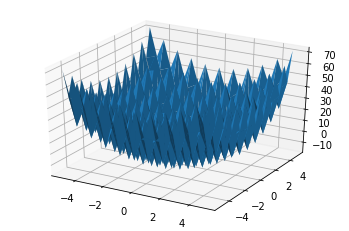

In [73]:
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
 
xy = np.mgrid[-5:5.1:0.5, -5:5.1:0.5].reshape(2,-1).T
# result = rastrigin(xy)
result = np.array([rastrigin(v) for v in xy])
 
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(xy.T[0], xy.T[1], result, linewidth=0.1, antialiased=True)    
plt.savefig('rastrigin.png')

In [67]:
len(result)

441

In [68]:
len(xy)

441

In [69]:
len(xy.T[0])

441